# STEP 1 : Understanding the Data

In [128]:
#Libraries for data frame

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings ("ignore")
                         

#Libraries for data visualization 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(style = 'darkgrid')

In [129]:
#File reading

path = '/Users/wisdomaniac/Google Drive/PROJETS/DATA Science/PORTFOLIO/DS-Project/Uber Supply-Demand GAP/Uber Request Data.csv'
uber = pd.read_csv(path)

In [130]:
#Data frame dimensions
uber.shape

(6745, 6)

In [131]:
#Statistic descriptions of Data Frame
uber.describe()

,Request id,Driver id
count,6745.000000,4095.000000
mean,3384.644922,149.501343
std,1955.099667,86.051994
min,1.000000,1.000000
25%,1691.000000,75.000000
50%,3387.000000,149.000000
75%,5080.000000,224.000000
max,6766.000000,300.000000


In [132]:
#Data frame info

uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


# STEP 2 : Data Cleaning and Preparation

To better understand cancellation and non-availability of cars we need to transform the data type of Request and Drop timestamp from object to datatime. 

From there we can then observe requests hours by hours each day, leading to a better understanding of supply and demand Gap.

In [133]:
#Check duplicates record 
sum(uber.duplicated())

0

In [134]:
#Pourcentage de valeur manquantes par colonne

uber_null = uber.isna().mean().round(4)*100

uber_null.sort_values(ascending = False)

Drop timestamp       58.03
Driver id            39.29
Request id            0.00
Pickup point          0.00
Status                0.00
Request timestamp     0.00
dtype: float64

**Inference:**

- 58% of Drop Time is null because of canceled trips.
- 39% of Driver Id null because of canceled trips

In [135]:
uber ['Request timestamp']

0           11/7/2016 11:51
1           11/7/2016 17:57
2            12/7/2016 9:17
3           12/7/2016 21:08
4       13-07-2016 08:33:16
               ...         
6740    15-07-2016 23:49:03
6741    15-07-2016 23:50:05
6742    15-07-2016 23:52:06
6743    15-07-2016 23:54:39
6744    15-07-2016 23:55:03
Name: Request timestamp, Length: 6745, dtype: object

In [136]:
#Transform Request timestamp (type : object) to Datetime object.

uber ['Request timestamp'] = uber ['Request timestamp'].astype(str)
uber ['Request timestamp'] = uber ['Request timestamp'].str.replace('/','-')
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'], format = 'mixed',  dayfirst= True)

In [137]:
#Transform Drop timestamp (type : object) to Datetime object.

uber ['Drop timestamp'] = uber ['Drop timestamp'].astype(str)
uber ['Drop timestamp'] = uber ['Drop timestamp'].str.replace('/','-')
uber['Drop timestamp'] = pd.to_datetime(uber['Drop timestamp'], format = 'mixed',  dayfirst= True)

In [138]:
#Extract the hour from the request timestamp (dt) and creating a new column

rq_h = uber['Request timestamp'].dt.hour

uber['Rq hours'] = rq_h

In [139]:
#Extract the day from the request timestamp (dt) and creating a new column

rq_d = uber['Request timestamp'].dt.day

uber['Rq days'] = rq_d

# STEP 3 : Data Visualization

In [140]:
#Function to visualize proportion of requests 
def pie_chart(df): 
    
    labels = df['Status'].value_counts().index
    sizes = df['Status'].value_counts()

    fig, axs = plt.subplots()
    axs.pie(sizes, labels = labels,  autopct = '%1.1f%%')
    plt.show()

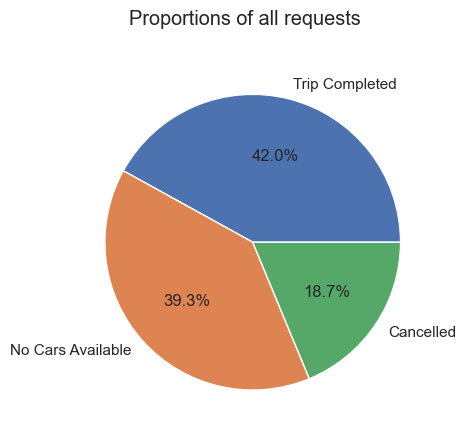

In [156]:
pie_chart(uber)
plt.suptitle('Proportions of all requests')
plt.show()

## Observation

- A gap exist between supply and demand trips.
- Only 42% of all airport/city requests are completed

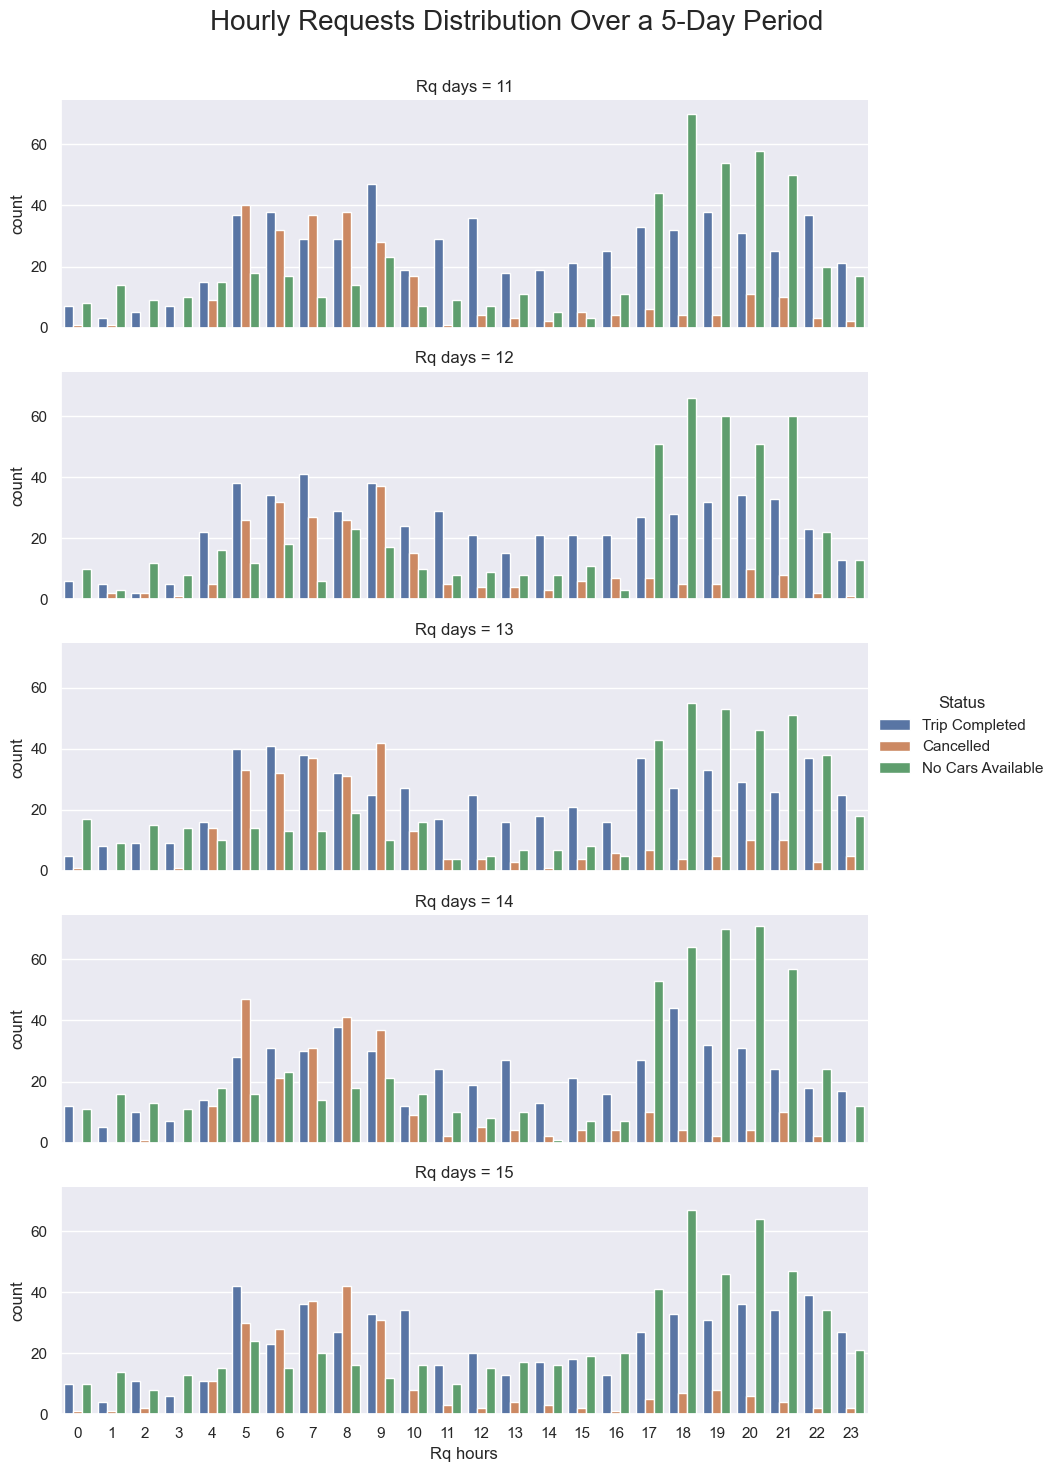

In [142]:
# Visualizing hourly requests distribution over days.

plot1 = sns.catplot(data = uber, x ='Rq hours', hue = 'Status', row = 'Rq days', kind ='count', height = 3, aspect = 3)
plot1.fig.subplots_adjust(top=0.92)
plot1.fig.suptitle('Hourly Requests Distribution Over a 5-Day Period', size = 20)
plt.show()

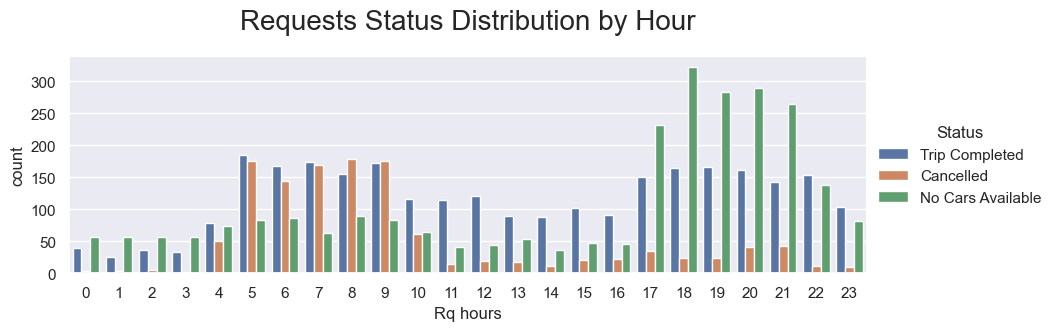

In [143]:
# Visualizing requests status ditribution by hour

sns.catplot(data = uber, x ='Rq hours', hue = 'Status', kind ='count', height = 3, aspect = 3)
plt.title('Requests Status Distribution by Hour', fontsize=20, pad = 20)
plt.show()

## Observation

- Most cancellation occurs between 5 AM to 10 AM
- Most non-availability cars situation occurs between 17 PM and 22 PM
- Cancellation and non availability issues depend mostly on the hours of day. 

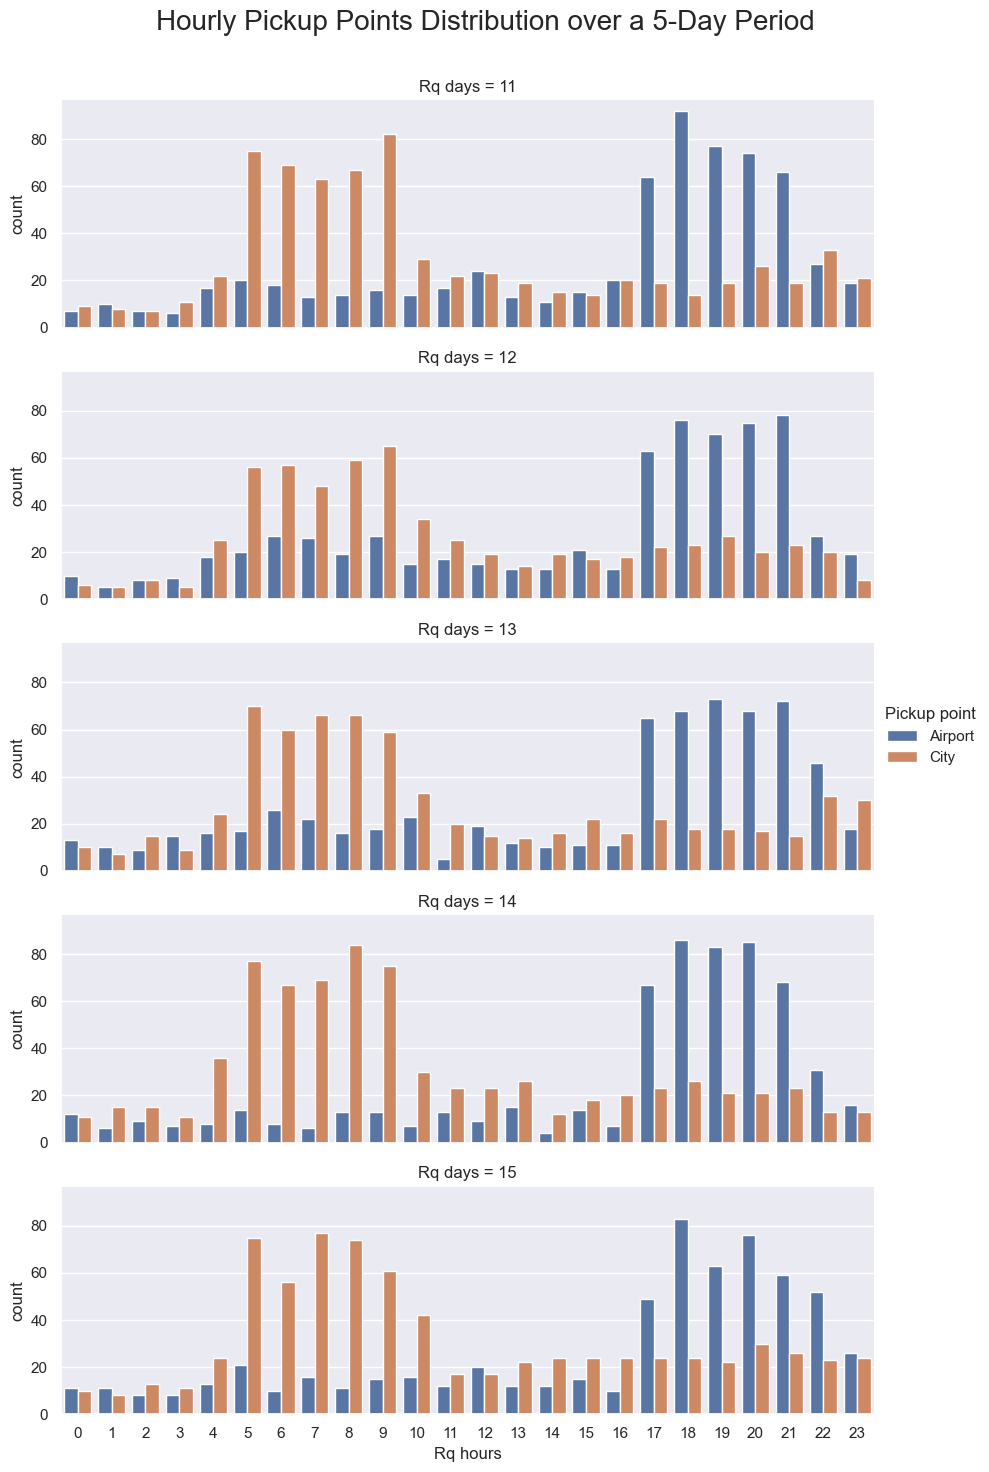

In [144]:
# Visualizing pickup points distribution over days.

plot2 = sns.catplot(data = uber, x ='Rq hours', hue = 'Pickup point', row = 'Rq days', kind ='count', height = 3, aspect = 3)
plot2.fig.subplots_adjust(top=0.92)
plot2.fig.suptitle('Hourly Pickup Points Distribution over a 5-Day Period', size = 20)
plt.show()

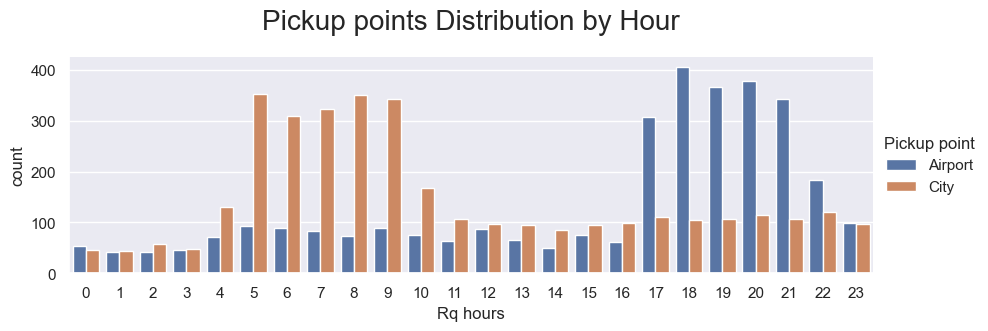

In [145]:
# Visualizing Pickup points Distribution by Hour

sns.catplot(data = uber, x ='Rq hours', hue = 'Pickup point', kind ='count', height = 3, aspect = 3)
plt.title('Pickup points Distribution by Hour', fontsize=20, pad = 20)
plt.show()

## Observations

- Most travel in the morning (5 AM to 10 AM) are from city to airport. 
- Most travel in the evening (17 PM and 22 PM) are from airport to city.


**This suggest two things each day :** 

- a morning rush from city to airport between 5 AM to 10 AM. 
- an evening rush from airport to city between 17 PM to 22 PM.


Lets create time slots to better understand the relation between cancellation, non availability cars and the day time.

In [146]:
# Create time slot with regard to the time hour. 

time_hour = [0, 5, 10, 17, 22, 24]
time_slots = ['Early Morning', 'Morning rush', 'Day time', 'Evening rush', 'Late Night']
uber ['Time slot'] = pd.cut(uber['Rq hours'], bins = time_hour, labels = time_slots)

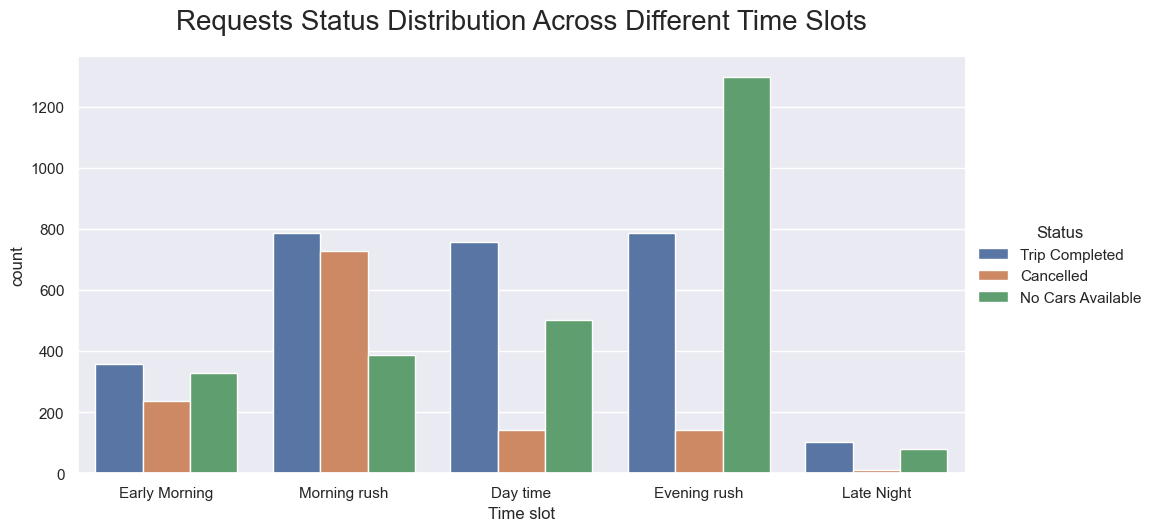

In [147]:
#Visualizing Requests Status Distribution Across Different Time Slots.

sns.catplot(data = uber, x ='Time slot', hue = 'Status', kind ='count', height = 5, aspect = 2)
plt.title('Requests Status Distribution Across Different Time Slots', fontsize=20, pad = 20)
plt.show()

## Observations

- Most cancellation occurs in the morning, particularly in the morning  rush 
- Most none-availability cars situations occurs in the evening particularly in the evening rush. 


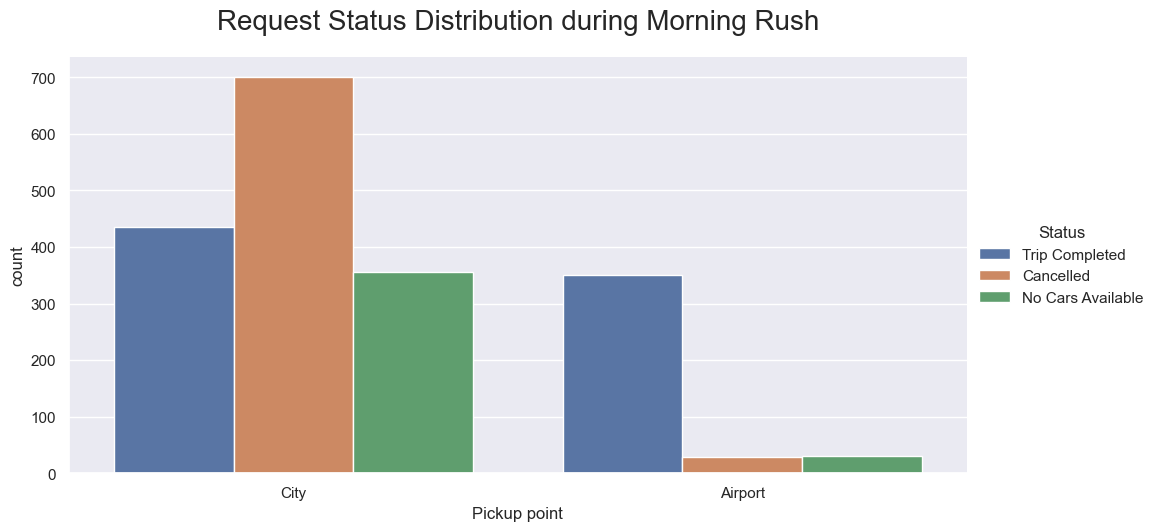

In [148]:
#Visualizing the Request Status Distribution during Morning Rush

morning_rush = uber[uber['Time slot'] == 'Morning rush']

sns.catplot(data = morning_rush, x ='Pickup point', hue = 'Status', kind ='count', height = 5, aspect = 2)
plt.title('Request Status Distribution during Morning Rush', fontsize=20, pad = 20)
plt.show()

## Observations

- Most cancellation occurs during the morning rush for trip City to airport request.


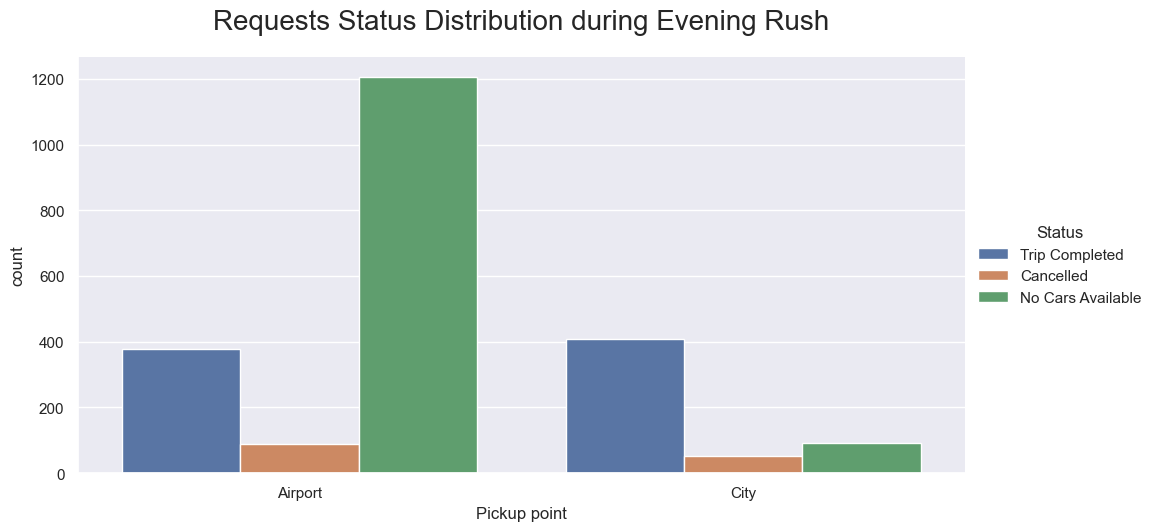

In [149]:
# Visualizing Requests Status Distribution during Evening Rush

evening_rush = uber[uber['Time slot'] == 'Evening rush']

sns.catplot(data = evening_rush, x ='Pickup point', hue = 'Status', kind ='count', height = 5, aspect = 2)
plt.title('Requests Status Distribution during Evening Rush', fontsize=20, pad = 20)
plt.show()


## Observations

- Most none-available cars situations occurs during the evening rush for trip from airport to city


**Lets create a pie chart to compare those proportions**


In [150]:
uber.loc[(uber.Status == 'Trip Completed') | (uber.Status == 'Cancelled')| (uber.Status == 'No Cars Available'), 'demand'] = 'Demand' 

In [151]:
#Creating 4 news variables to compare request status distribution by Time slot & pickup point

city_morning_rush = uber[(uber['Time slot'] == 'Morning rush') & (uber['Pickup point'] == 'City')]

airport_morning_rush = uber[(uber['Time slot'] == 'Morning rush') & (uber['Pickup point'] == 'Airport')]

city_evening_rush = uber[(uber['Time slot'] == 'Evening rush') & (uber['Pickup point'] == 'City')]

airport_evening_rush = uber[(uber['Time slot'] == 'Evening rush') & (uber['Pickup point'] == 'Airport')]

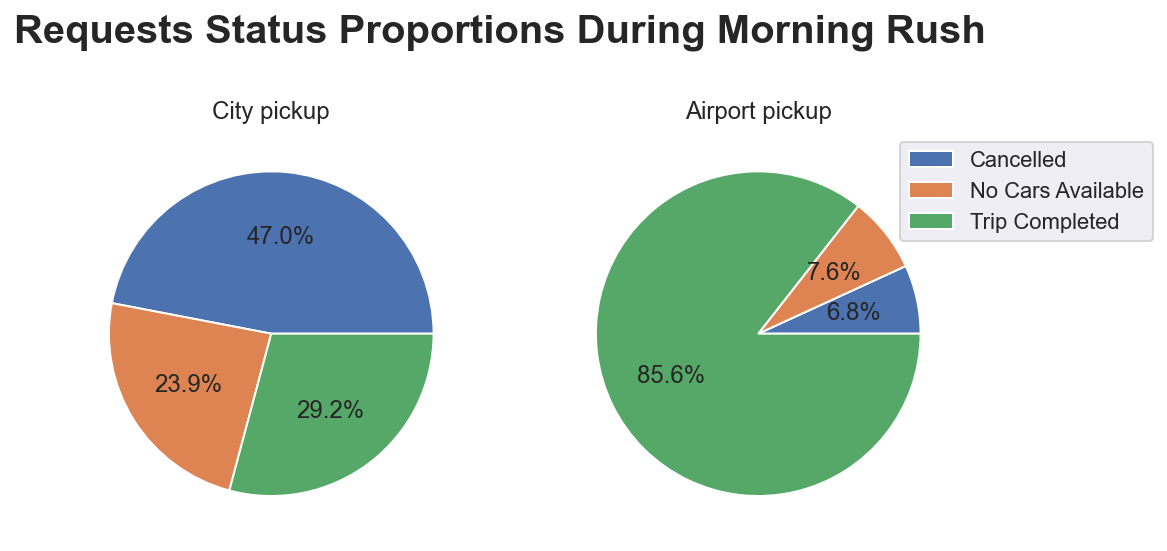

In [152]:
#Visualizing Request Status During Morning Rush by Pickup Location


fig, axes = plt.subplots(1,2, figsize= (8,4), dpi= 144)
plt.suptitle('Requests Status Proportions During Morning Rush', y=1.05, fontweight = 'bold', fontsize=20)

for ax, df, title in zip (axes, (city_morning_rush,airport_morning_rush), ('City pickup', 'Airport pickup')):
    labels = df['Status'].value_counts().sort_index().index
    sizes = df['Status'].value_counts().sort_index()
    ax.pie(sizes, autopct = '%1.1f%%')
    ax.set_title(title)
    plt.legend(labels, loc = 'best', bbox_to_anchor = (1, 0.5, 0.5, 0.5))

## Observations

- During morning rush, trips from city to airport are responsible for the bigger part of lost revenu. 

- 47% of request are canceled by drivers. 

- 24% of request can't be answered because of none-availability

**Inference :**

There is a gap between request from city to airport vs from
airport to city.

The city-airport request aren't profitable enough for drivers (avoid empty trips). 

There is not enough active drivers close to city to manage morning
city-airport requests. 

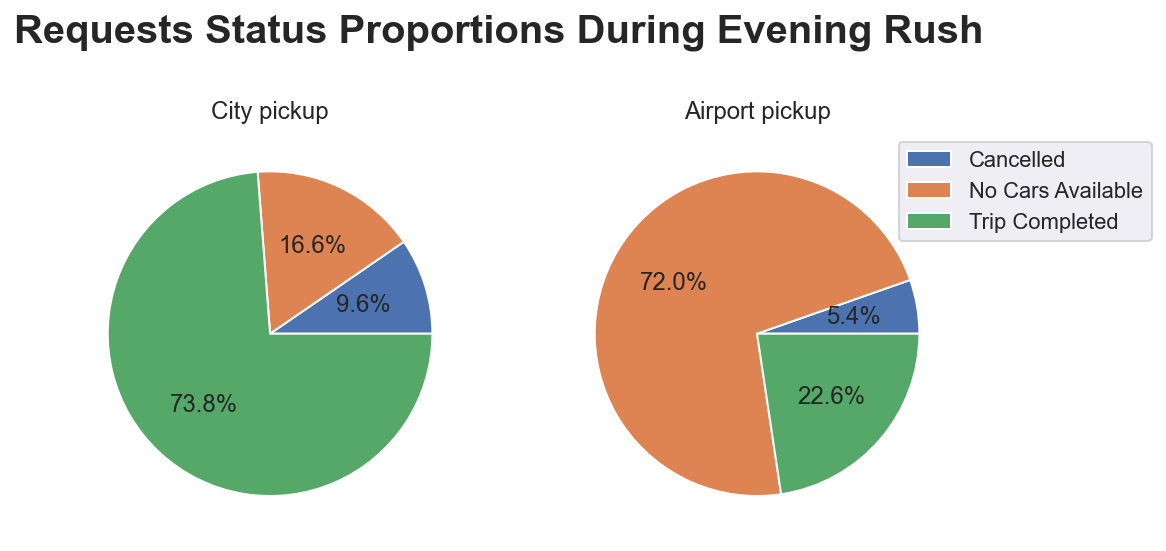

In [153]:
#Visualizing Request Status During Evening Rush by Pickup Location


fig, axes = plt.subplots(1,2, figsize= (8,4), dpi= 144)
plt.suptitle('Requests Status Proportions During Evening Rush', y=1.05, fontweight = 'bold', fontsize=20)

for ax, df, title in zip (axes, (city_evening_rush, airport_evening_rush), ('City pickup', 'Airport pickup')):
    labels = df['Status'].value_counts().sort_index().index
    sizes = df['Status'].value_counts().sort_index()
    ax.pie(sizes, autopct = '%1.1f%%')
    ax.set_title(title)
    plt.legend(labels, loc = 'best', bbox_to_anchor = (1, 0.5, 0.5, 0.5))

## Observations

- During evening rush, trips from airport to city are responsible for the bigger part of lost revenu. 

- 72% of request can't be answered because of none-availability

**Inference :**

There is a gap between request from city to airport vs from
airport to city.

There is not enough active drivers close to airport to manage evening
airport-city requests. 

Drivers answer to other kind of request (city-city). 

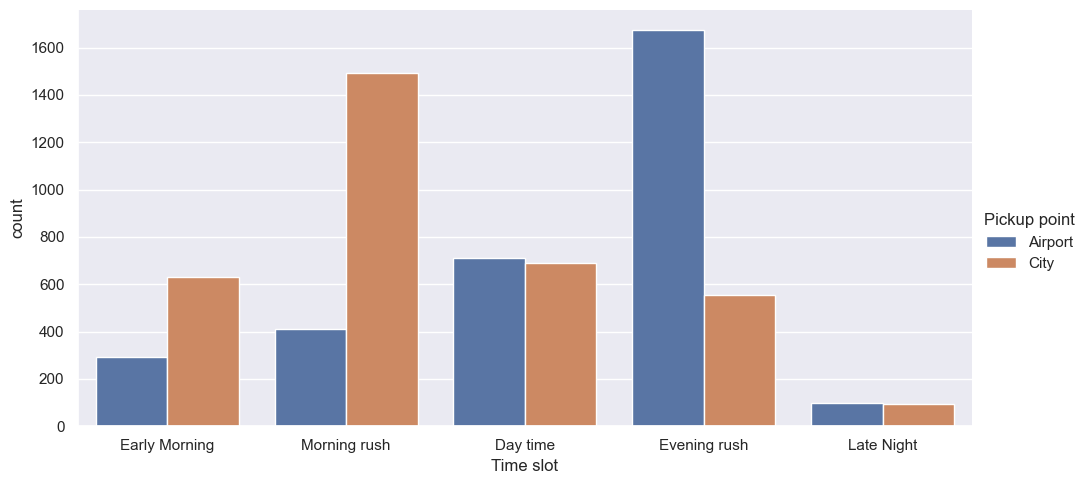

In [154]:
#Visualizing the different time slot with regard to the Status.

sns.catplot(data = uber, x ='Time slot', hue = 'Pickup point', kind ='count', height = 5, aspect = 2)

## Observations

During the morning rush, there are around : 
- 400 requests from airport to city
- 1500 requests from city to airport

During evening rush,there are around : 
- 1700 requests from airport to city
- 590 requests from city to airport

There is a clear gap in demand during morning rush and evening rush.
The supply/demand gap reverse between morning rush and evening rush

# Conclusion

## Observations
- Only 42% of airport/city requests are completed due to a supply and demand gap.
- This gap varies mostly by the hour of the day.
- Most revenue loss occurs during two critical periods: morning rush (5 to 10 AM) and evening rush (5 to 10 PM).
- The supply/demand gap flips between morning and evening rush hours.
- Rush hours lead to more non-availability and cancellations.
- Non-availability happens because there aren't enough drivers in high-demand areas during rush hours.
- Cancellations occur because drivers prefer more profitable requests during rush hours.

## Inference 
#### Morning Rush Hypothesis:
In the morning rush, most people go to the airport and fewer to the city. This creates a demand gap. As more drivers go to the airport, fewer are available in the city, leading to non-availability for city requests.

Additionally, requests from the city to the airport are less profitable for drivers because they often result in an empty return trip. This could lead to cancellations as drivers wait for more profitable requests (e.g., city-to-city trips).

#### Evening Rush Hypothesis:
In the evening rush, the opposite happens: most people go to the city and fewer to the airport. This creates a demand gap. As more drivers go to the city, fewer are available at the airport, leading to non-availability for airport requests.

Additionally, there are more profitable requests within the city that drivers prefer to take.



## Possible solutions to fill the supply demand gap : 
1. Incentives for Drivers:

- Implement dynamic pricing to increase fares during peak times, making it more attractive for drivers to accept trips to high-demand areas.
- Provide bonuses or higher rates for drivers working flexible hours during peak times.
- Create a pool of part-time or on-call drivers who can be activated during peak times.
- Cancellation penalty : Set threshold for maximum cancellation. 

2. Enhanced Communication and Training:

- Improve communication with drivers through real-time updates about high-demand areas and potential earnings.
- Implement training programs to educate drivers on how to maximize their earnings and efficiency, including strategies for managing peak demand periods.

3. Data-Driven Strategies:

- Utilize data analytics to predict high-demand periods and proactively inform drivers where and when they are needed most.
- Improve ride-matching algorithms to better pair drivers with passengers, minimizing idle time and maximizing efficiency.
- Use geofencing technology to create virtual boundaries around high-demand areas, ensuring more drivers are available in these zones during peak times.

4. Customer Management:

- Offer discounts or promotions to customers who book trips during non-peak hours to help spread demand more evenly throughout the day.
- Educate customers about the benefits of pre-booking their rides, especially for airport trips, to allow for better planning and resource allocation.
- Car sharing : allow care sharing when there are not enough drivers available.


5. Strategic Partnerships and Adjustments:

- Partner with local businesses, hotels, and airlines to provide a steady stream of airport-city requests and offer drivers a consistent flow of passengers.
- Adjust strategies based on seasonal variations in demand, such as holiday travel surges, to ensure adequate driver availability.



## Possible solutions to better understand the problem : 


1. Data Collection and Advanced analytics (forcasting driver shortages,  heatmaps for critical areas)

2. Customer and Driver Feedback (surveys, booking pattern, pain points)

3. Driver Behavior and Performance Analysis (preferences, factors, economic impact, acceptances/cancellation rate) 

4. Operational Analysis and Audits (processes, systems vs peaks, real time monitoring)

5. External and Competitive Analysis (Case studies, external factors, competitors)